# Inicjalizacja środowiska

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score
warnings.filterwarnings('ignore')
from math import log

## Funkcje pomocnicze

In [ ]:
def searchBestCValue(solver, penalty, X_train, y_train, X_val, y_val, min, max, step):
    val_scores = []
    train_scores = []
    values = []
    for C in np.arange(min, max, step):
        model = LogisticRegression(random_state=None, solver=solver, penalty=penalty, C=C).fit(X_train, y_train)
        score = model.score(X_val, y_val)
        val_scores.append(score)
        score = model.score(X_train, y_train)
        train_scores.append(score)
        values.append(C)
    return val_scores, train_scores, values

def testModelParameters(solver, penalty, X_train, y_train, X_val, y_val, plot=True, print_result=True):
    #0.1 2 0.01
    #0.01, 20, 0.5
    val_scores, train_scores, values = searchBestCValue('liblinear', 'l1', X_train, y_train, X_val, y_val, 0.01, 20, 0.5)
    if (plot):
        plt.figure()
        plt.plot(values, val_scores)
        plt.plot(values, train_scores)
        plt.show()
    max = np.max(val_scores)
    idx = val_scores.index(max)
    C = values[idx]
    if(print_result):
        print("Największa skutecznośc na zbiorze walidacyjnym: %.4f \ndla współczynnika C = %.4f" %(max, C))
    return solver, penalty, C, max


# Dane wypełnione medianami

## Wczytanie danych

In [4]:
data = pd.read_csv("data/imputated_data.csv")
data = data.drop(['Imputated'], axis=1)
data = data.drop(['Unnamed: 0'], axis=1)

## Dodanie dodatkowych cech

Funkcje interakcji najlepiej sprawdzają się w przypadku cech, które na wykresie cecha1(cecha2) układają się mniej więcej wzdłuż funkcji x=y oraz wraz z x rośnie prawdopodobieństwo wystąpienia pozytywnej decyzji. Z pomocą wykresów korelacji znalazłem jeden taki przypadek: Glucose oraz BMI.

In [110]:
data['InsulinSquared'] = data['Insulin'].apply(lambda x: x**2)
data['GlucoseSquared'] = data['Glucose'].apply(lambda x: x**2)
data['InsulinGlucose'] = data['Insulin'] * data['Glucose']
data['BMISquared'] = data['BMI'].apply(lambda x:(x**2))
data['GlucoseBMI'] = data['Glucose'] * data['BMI']
data['InsulinLog'] = data['Insulin'].apply(lambda x: log(x))
data['BloodPressureSquared'] =  data['BloodPressure'].apply(lambda x: x**2)
data['SkinThicknessBMI'] = data['BMI'] * data['SkinThickness']

## Podział danych
* Podział na zbiory X (cehcy opisujące) oraz Y (cecha opisywana). Dla tego zbioru Y to "Outcome", czyli diagnoza.
* Podział na zbiory Train/Test/Val - procentowy podział w komentarzu funkcji splitDataset()

In [6]:
def splitDataset(X, y, random_state=0, print_result=False):
    #Podział Train 60%, Test 20%, Val 20%
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.4, random_state=0)
    #0.5 * 0.4 = 0.2
    X_test, X_val, y_test, y_val = train_test_split(X_test, y_test, test_size=0.5, random_state=0)
    print("Zbiór podzielony: TRAIN: %i, VAL: %i, TEST: %i" % (X_train.shape[0],X_val.shape[0],X_test.shape[0]))
    return X_train, y_train, X_test, y_test, X_val, y_val

In [111]:
y = data['Outcome']
X = data.drop(["Outcome"], axis=1)

In [112]:
X_train, y_train, X_test, y_test, X_val, y_val = splitDataset(X, y, 0, print_result=True)

Zbiór podzielony: TRAIN: 451, VAL: 151, TEST: 150


### Wybór ilości cech

In [124]:
features = X.columns.values.tolist()
result_features = []

cv_scores = []
test_scores = []
feature_numbers = []

model = LogisticRegression(random_state=0, solver='liblinear', penalty='l1', C=4.1)
for n in range(0,len(features)):
    tmp_max_score = 0
    tmp_test_score = 0
    best_features = []
    for i,val in enumerate(features):
        tmp_features = result_features.copy()
        tmp_features.append(val)
        score = cross_val_score(model, X_train[tmp_features], y_train)
        score = np.abs(score).mean()
        fitted_model = model.fit(X_train[tmp_features], y_train)
        test_score = fitted_model.score(X_test[tmp_features], y_test)
        if( score > tmp_max_score ):
            tmp_max_score = score
            best_features = tmp_features
            tmp_test_score = test_score
    result_features = best_features
    print("Dla tego etapu najlepszy wynik wynosi cv_score: %.4f , test_score: %.4f dla zbioru cech:\n%s" % (tmp_max_score, tmp_test_score, str(best_features)))
    cv_scores.append(tmp_max_score)
    test_scores.append(tmp_test_score)
    feature_numbers.append(len(best_features))
    solver, penalty, C, max = testModelParameters('liblinear','l1', X_train[best_features], y_train, X_val[best_features], y_val, plot=False, print_result=False)
    print("Dla najlepszego współczynnika C = %f maksymalna skuteczność na zbiorze walidacyjnym wynosi %.4f" % (C,max))
    print("___________________________________________________________________________")
    features.remove(best_features[len(best_features)-1])

Dla tego etapu najlepszy wynik wynosi cv_score: 0.7537 , test_score: 0.7467 dla zbioru cech:
['GlucoseBMI']
Dla najlepszego współczynnika C = 0.510000 maksymalna skuteczność na zbiorze walidacyjnym wynosi 0.7881
___________________________________________________________________________
Dla tego etapu najlepszy wynik wynosi cv_score: 0.7537 , test_score: 0.7400 dla zbioru cech:
['GlucoseBMI', 'DiabetesPedigreeFunction']
Dla najlepszego współczynnika C = 4.510000 maksymalna skuteczność na zbiorze walidacyjnym wynosi 0.8013
___________________________________________________________________________
Dla tego etapu najlepszy wynik wynosi cv_score: 0.7582 , test_score: 0.7667 dla zbioru cech:
['GlucoseBMI', 'DiabetesPedigreeFunction', 'BMI']
Dla najlepszego współczynnika C = 7.510000 maksymalna skuteczność na zbiorze walidacyjnym wynosi 0.8079
___________________________________________________________________________
Dla tego etapu najlepszy wynik wynosi cv_score: 0.7537 , test_score: 0.76

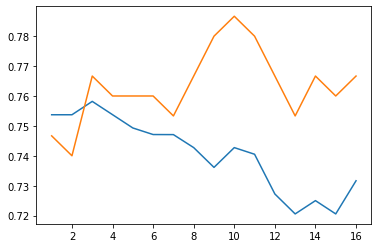

In [118]:
plt.figure()
plt.plot(feature_numbers, cv_scores)
plt.plot(feature_numbers, test_scores)
plt.show()

In [125]:
features = ['GlucoseBMI', 'DiabetesPedigreeFunction', 'BMI', 'GlucoseSquared', 'BloodPressure', 'BloodPressureSquared', 'SkinThickness', 'Age']

## Dobór parametrów

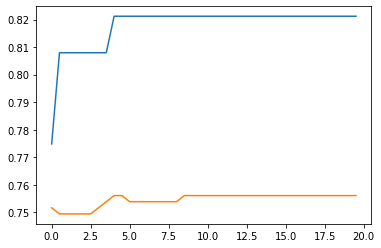

Największa skutecznośc na zbiorze walidacyjnym: 0.8212 
dla współczynnika C = 4.0100


In [126]:
solver, penalty, C, max = testModelParameters('liblinear','l1', X_train[features], y_train, X_val[features], y_val)

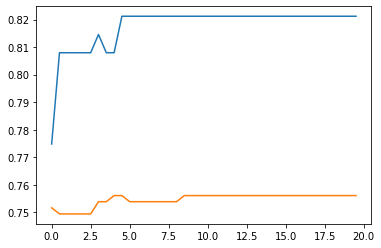

Największa skutecznośc na zbiorze walidacyjnym: 0.8212 
dla współczynnika C = 4.5100


In [128]:
solver, penalty, C, max = testModelParameters('liblinear','elasticnet', X_train[features], y_train, X_val[features], y_val)

In [135]:
model = LogisticRegression(random_state=0, solver='liblinear', penalty='l1', C=4.01).fit(X_train[features], y_train)

In [156]:
model.coef_

array([[ 1.09275862e-03,  1.97604909e-01, -4.64243281e-02,
        -8.50223874e-06, -4.12098380e-02,  2.12167545e-04,
        -6.81070645e-03,  3.40763486e-02]])

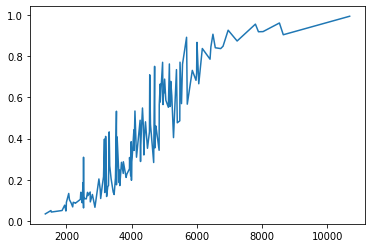

In [158]:
sorted = X_test.sort_values(by="GlucoseBMI")
model_values = (model.predict_proba(sorted[features]))
model_values[:,1]
plt.plot(sorted['GlucoseBMI'], model_values[:,1])

In [10]:
from sklearn import metrics
model = LogisticRegression(solver='liblinear', penalty='l1', C=1.64).fit(X_train, y_train)
score = cross_val_score(model, X_train, y_train, cv=10)
prediction = model.predict(X_test)
err = metrics.mean_squared_error(y_true=y_test, y_pred=prediction)
print(err)
avg_score = np.abs(score).mean()
print(score)
print(avg_score)
model.coef_

0.23333333333333334
[0.7826087  0.77777778 0.75555556 0.66666667 0.8        0.73333333
 0.71111111 0.66666667 0.8        0.71111111]
0.7404830917874395


array([[ 1.26556132e-01,  6.89722746e-02, -1.75786401e-02,
         1.30454007e-03,  2.59587583e-02,  1.19264477e-01,
         5.50514550e-01,  9.56889850e-03, -5.26263796e-05,
        -2.14525423e-04,  1.12279554e-04, -1.32552348e-03,
         4.80947966e-04, -3.05398931e+00]])

In [33]:
model = LogisticRegression(random_state=None, solver='liblinear', penalty='l1', C=1.64).fit(X_train, y_train)
score = cross_val_score(model, X_train, y_train)
avg_score = np.abs(score).mean()
print(score)
print(avg_score)
model.coef_

[0.79120879 0.66666667 0.76666667 0.67777778 0.73333333]
0.7271306471306472


array([[ 1.20879065e-01,  3.04775990e-02, -1.53268620e-02,
        -2.51776486e-03, -9.51054680e-03,  0.00000000e+00,
         3.03496080e-01,  1.41600935e-02, -8.69703874e-06,
        -1.42046078e-04,  7.40911263e-05, -7.96336899e-04,
         1.16124714e-03]])

In [61]:
idx = 8
model = LogisticRegression(random_state=0, solver='liblinear', penalty='l1',C=1.69).fit(X_train, y_train)
prediction = model.predict_proba(X.iloc[idx,:].values.reshape(1,-1))
print(prediction)
prediction = model.predict(X.iloc[idx,:].values.reshape(1,-1))
print(prediction)
pinw = np.linalg.pinv(X_train)
w = np.dot(pinw,y_train)
prediction = (w*X.iloc[idx,:]).sum()
print(prediction)
print(y.iloc[idx])

[[0.17883669 0.82116331]]
[1]
0.6922917900197856
1


In [83]:
print("Metoda macierzowa")
y_pred = ((w*X_val).sum(axis=1) > 0.5) * 1
print(metrics.confusion_matrix(y_val, y_pred))

print("LogisticRegression")
model = LogisticRegression(random_state=0, solver='liblinear', penalty='l1',C=4.51).fit(X_train, y_train)
y_pred = model.predict(X_val)
print(metrics.confusion_matrix(y_val, y_pred))

Metoda macierzowa
[[92 12]
 [17 30]]
LogisticRegression
[[92 12]
 [15 32]]


In [74]:
y_pred = ((w*X_test).sum(axis=1) > 0.5) * 1
correct = (y_pred == y_test).sum()
correct/len(y_pred)

0.7733333333333333

In [86]:
model = LogisticRegression(random_state=0, solver='liblinear', penalty='l1',C=1.69).fit(X_train, y_train)
model.score(X_test, y_test)
print(model.coef_)
y_pred = model.predict(X_val)
metrics.roc_auc_score(y_val,y_pred )

[[ 1.25840154e-01  6.08128459e-02 -1.71398830e-02  1.12659022e-03
   2.38570027e-02  1.04679083e-01  5.34846100e-01  1.00882071e-02
  -4.93796265e-05 -1.96511440e-04  1.06463493e-04 -1.31885213e-03
   5.94369528e-04 -2.83807672e+00]]


0.7508183306055647

In [35]:

model = LogisticRegression(random_state=None, solver='liblinear', penalty='l1', C=1.49).fit(X_train, y_train)
scores = cross_val_score(model, X, y, cv=5 )
print(scores)
print(model.coef_)

[0.7615894  0.74834437 0.76       0.78666667 0.77333333]
[[ 1.22858438e-01  7.52431789e-02 -1.43070719e-02 -2.80329383e-03
  -1.24195789e-02  8.60426555e-02  3.46797701e-01  1.05454765e-02
  -9.07960153e-06 -1.71996077e-04  9.62394085e-05]]


In [36]:

scores = cross_val_score(model, X, y, cv=5)
scores

array([0.7615894 , 0.74834437, 0.76      , 0.78666667, 0.77333333])

# Testowanie modelu #
#TODO

# Wypełnienie braków przy użyciu regresji
#TODO